In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import os


In [3]:
df = pd.read_csv("/workspaces/CS_Group_09_Salary_prediction/data/Salary_Data.csv")
df_original = df.copy()

In [4]:
#Handle missing values 

df.dropna(inplace=True)

In [5]:
#Remove duplicate rows

df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

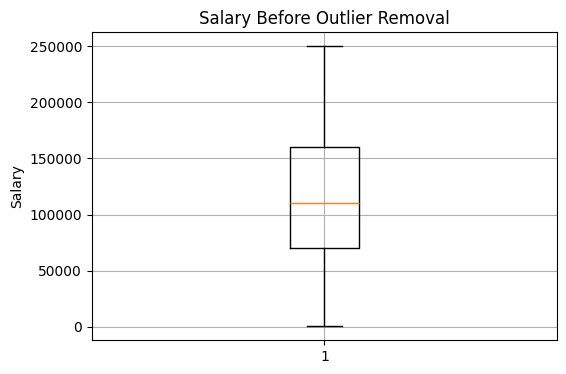

In [6]:
# Boxplot before outlier removal

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(df["Salary"])
plt.title("Salary Before Outlier Removal")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

# # Remove outliers using IQR method

# q1, q3 = np.percentile(df["Salary"], [25, 75])
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# # Filter the dataframe
# df = df[(df["Salary"] >= lower_bound) & (df["Salary"] <= upper_bound)]



In [7]:
#Remove outliers from all numerical columns using IQR 
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

# Filter out outliers for this column

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
#Reset index after filtering outliers

df.reset_index(drop=True, inplace=True)

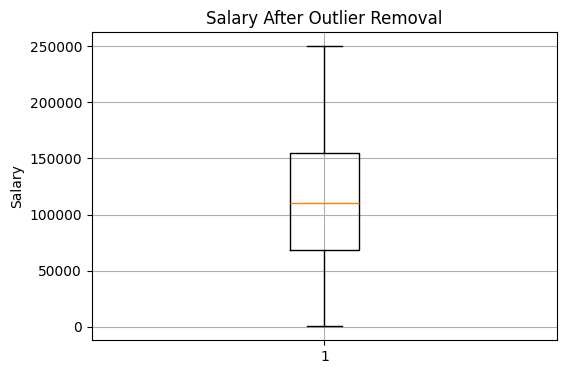

In [8]:
# Boxplot after outlier removal
plt.figure(figsize=(6, 4))
plt.boxplot(df["Salary"])
plt.title("Salary After Outlier Removal")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

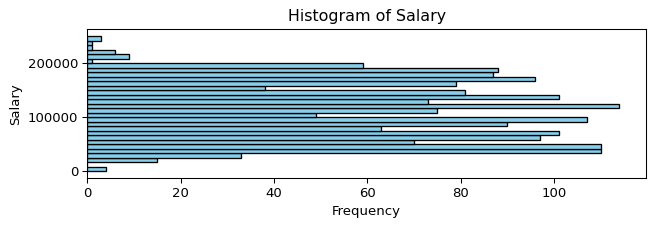

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Select only numerical columns
numeric_cols = ["Salary"]

# Create one subplot per numeric column
fig, axs = plt.subplots(len(numeric_cols), 1, dpi=95, figsize=(7, len(numeric_cols) * 2.5))

# Loop through each column and plot its histogram
for i, col in enumerate(numeric_cols):
    # Check if axs is a single Axes object or an array of Axes objects
    if len(numeric_cols) == 1:
        current_ax = axs
    else:
        current_ax = axs[i]

    current_ax.hist(df[col], bins=30, color='skyblue', edgecolor='black', orientation='horizontal') # Set orientation='horizontal' for horizontal histograms
    current_ax.set_title(f"Histogram of {col}")
    current_ax.set_xlabel("Frequency") # Swap xlabel and ylabel for horizontal
    current_ax.set_ylabel(col) # Swap xlabel and ylabel for horizontal

plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import skew, kurtosis

print("Skewness:", skew(df['Salary']))
print("Kurtosis:", kurtosis(df['Salary']))

print("Original dataset size:", df_original.shape)
print("After removing outliers:", df.shape)
print(df.describe())


Skewness: 0.09642479691218055
Kurtosis: -1.0957167324545287
Original dataset size: (6704, 6)
After removing outliers: (1761, 6)
               Age  Years of Experience         Salary
count  1761.000000          1761.000000    1761.000000
mean     34.833049             8.863146  112120.273140
std       7.864077             6.430839   51180.245032
min      21.000000             0.000000     350.000000
25%      29.000000             3.000000   68000.000000
50%      33.000000             8.000000  110000.000000
75%      41.000000            13.000000  155000.000000
max      58.000000            28.000000  250000.000000


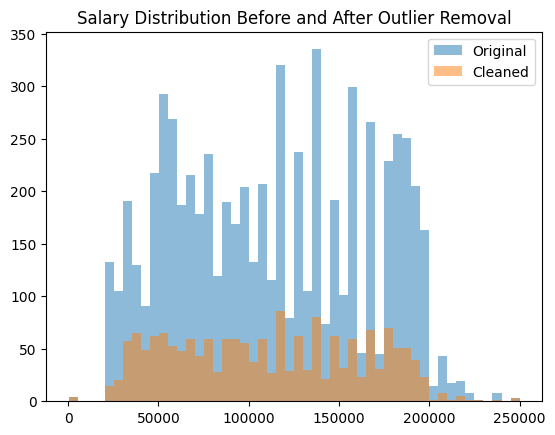

In [11]:
import matplotlib.pyplot as plt

plt.hist(df_original['Salary'], bins=50, alpha=0.5, label='Original')
plt.hist(df['Salary'], bins=50, alpha=0.5, label='Cleaned')
plt.legend()
plt.title("Salary Distribution Before and After Outlier Removal")
plt.show()

In [12]:
#Encode categorical variables

cat_cols = df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
else:
    print("No categorical columns to encode.")

In [13]:
correlation_with_target = df.corr()['Salary'].sort_values(ascending=False)
print(correlation_with_target)

Salary                                 1.000000
Years of Experience                    0.827170
Age                                    0.763189
Education Level_PhD                    0.440233
Job Title_Software Engineer Manager    0.288646
                                         ...   
Job Title_Sales Associate             -0.142570
Job Title_Junior HR Generalist        -0.150761
Job Title_Junior Sales Associate      -0.197108
Education Level_Bachelor's Degree     -0.273393
Education Level_High School           -0.347611
Name: Salary, Length: 201, dtype: float64


In [14]:
#Define features and target

X = df.drop('Salary', axis=1)
y = df['Salary']


In [15]:
#Train-test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [16]:
#Grid search hyperparameters

params = {
    'learning_rate': [0.1],
    'max_depth': [7],
    'n_estimators': [200],
    'subsample': [0.8]
}

grid = GridSearchCV(XGBRegressor(), params, cv=5, scoring='r2')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


In [17]:
#Evaluate model on test set

y_pred = best_model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("Mean Salary:", y.mean())
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))


R² Score: 0.9252972682923316
Mean Salary: 112120.27314026121
Mean Absolute Error (MAE): 8648.081920695755
Root Mean Squared Error (RMSE): 14075.985259737712
Mean Squared Error (MSE): 198133361.03235334


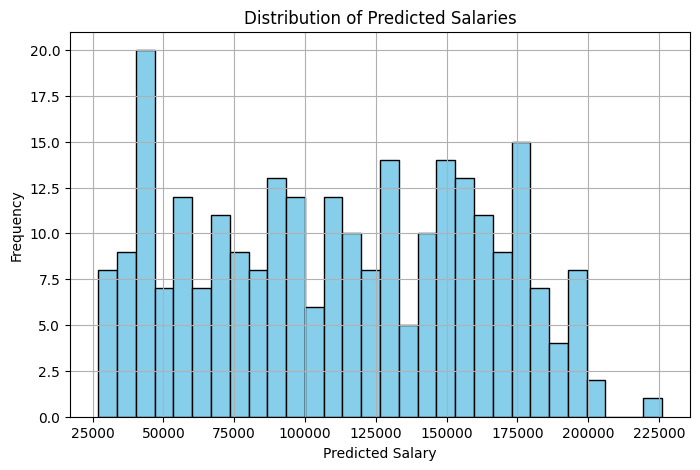

In [18]:
# Histogram of Predictions
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.hist(y_pred, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Salaries")
plt.xlabel("Predicted Salary")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


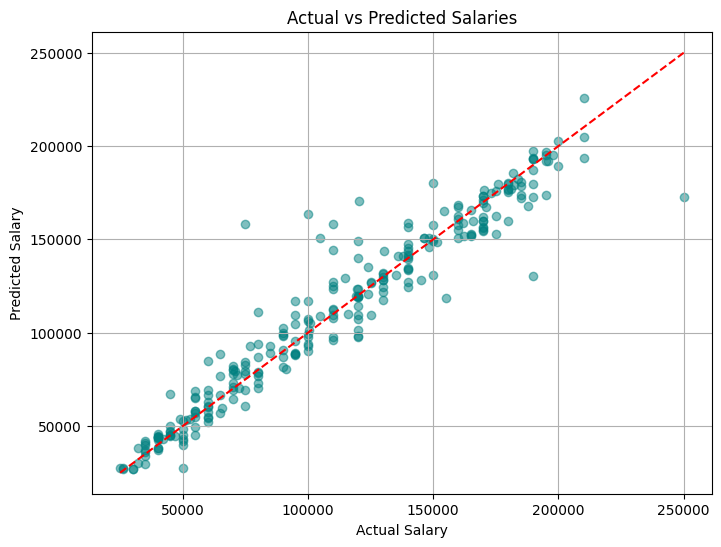

In [19]:
# Scatter Plot: True vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.title("Actual vs Predicted Salaries")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.grid(True)
plt.show()


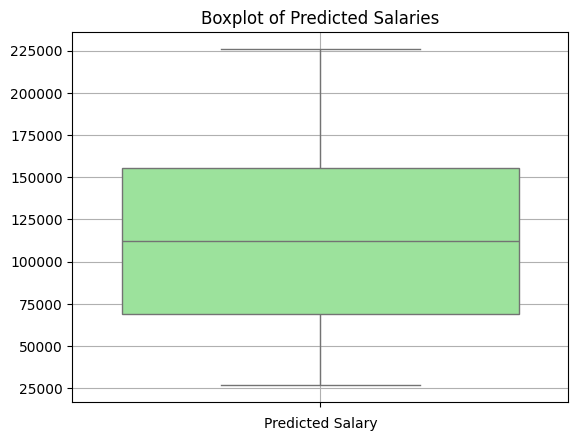

In [20]:
# Boxplot of Predicted Salaries
import seaborn as sns

sns.boxplot(y=y_pred, color='lightgreen')
plt.title("Boxplot of Predicted Salaries")
plt.xlabel("Predicted Salary")
plt.grid(True)
plt.show()


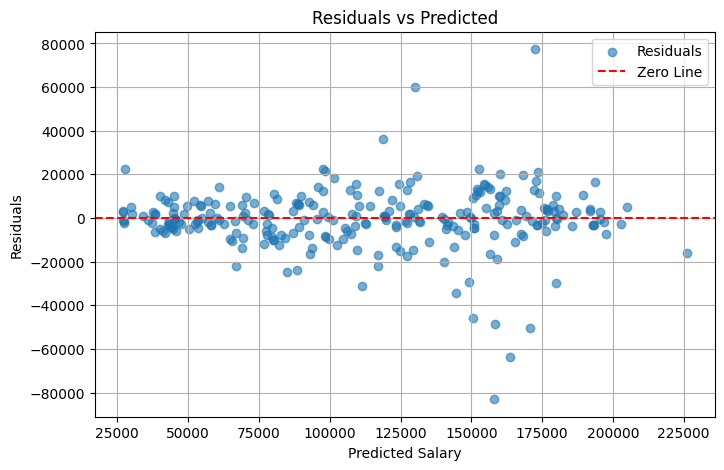

In [25]:
# Plot Residuals - Visualize the errors between predicted and actual values.
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.legend(['Residuals', 'Zero Line'])
plt.grid(True)
plt.show()


In [26]:
#Cross-validation R²

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Average R² from 5-fold CV:", cv_scores.mean())


Average R² from 5-fold CV: 0.6660427810064162


In [27]:
#Save the trained model 

joblib.dump(best_model, "model3.pkl")

['model3.pkl']